<a href="https://colab.research.google.com/github/jfpIE16/SL_I_Tareas/blob/master/ProyectoFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto Final
## Statistical Learning I
José Fernando Pérez Pérez

*josefernando.perez@galileo.edu*


---

El proyecto consiste en hacer clasificación binaria  para determinar si una persona sobrevive(y=1) o no (y=0) del hundimiento del Titanic.
El enunciado parece ser de un proyecto largo , pero es por que buscamos hacerlo detallado y poner ejemplos o referencias de cosas que pueden facilitar el trabajo.

En este proyecto se busca crear un modelo con un nivel de exactitud de al menos el 80%(aunque es posible crear modelos mejores que esto).


In [ ]:
# Importamos las librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font_scale=1.5)
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib

In [ ]:
# Cargamos Tensorflow y activamos compatibilidad con version 1.x
import tensorflow as tf
if tf.__version__.startswith("2."):
    import tensorflow.compat.v1 as tf
    tf.compat.v1.disable_v2_behavior()
    print("Enabled compatibility to tf1.x")

Cargamos dataset a un DataFrame de Pandas

In [3]:
titanic_df = pd.read_csv("/content/drive/My Drive/data_titanic_proyecto.csv", 
                         index_col="PassengerId")

### Descripción de las columnas

| Variable | Definition                                 | Key                                            |
|----------|--------------------------------------------|------------------------------------------------|
| survival | Survival                                   | 0 = No, 1 = Yes                                |
| pclass   | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                      |
| sex      | Sex                                        | M = Male, F = Female                           |
| Age      | Age in years                               |                                                |
| sibsp    | # of siblings / spouses aboard the Titanic |                                                |
| parch    | # of parents / children aboard the Titanic |                                                |
| ticket   | Ticket number                              |                                                |
| fare     | Passenger fare                             |                                                |
| cabin    | Cabin number                               |                                                |
| embarked | Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton |


## Descripción del conjunto de *Datos*

Observamos una pequeña muestra de los datos

In [4]:
titanic_df.head(5)

,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,passenger_class,passenger_sex,passenger_survived
PassengerId,,,,,,,,,,,
1,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,Lower,M,N
2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,Upper,F,Y
3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Lower,F,Y
4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,Upper,F,Y
5,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,Lower,M,N


Breve descripción de las columnas con valores númericos



In [5]:
titanic_df.describe()

,Age,SibSp,Parch,Fare
count,714.000000,891.000000,891.000000,891.000000
mean,29.699118,0.523008,0.381594,32.204208
std,14.526497,1.102743,0.806057,49.693429
min,0.420000,0.000000,0.000000,0.000000
25%,20.125000,0.000000,0.000000,7.910400
50%,28.000000,0.000000,0.000000,14.454200
75%,38.000000,1.000000,0.000000,31.000000
max,80.000000,8.000000,6.000000,512.329200


Verificamos columnas con valores nulos.


In [6]:
titanic_df.isnull().sum()

Name                    0
Age                   177
SibSp                   0
Parch                   0
Ticket                  0
Fare                    0
Cabin                 687
Embarked                2
passenger_class         0
passenger_sex           0
passenger_survived      0
dtype: int64

## Limpieza y Depuración de los Datos

Agregamos los valores restantes de *Age* como la mediana de la columna, *Cabin* una letra específica "N" y *Embarked* Z. La columna *passenger_survived* se procesa para tener un valor 1 si el valor es "Y" y 0 en otro caso.

Columnas nuevas:

- Sex: 1 - Masculino, 0 - Femenino
- Survived: 1 -> Y, 0 -> N
- Embarqued_"X": Columna para cada puerto
- "x"_class: Clase de boleto por pasajero. Columna para cada clase.

In [7]:
titanic_df['Age'] = titanic_df['Age'].fillna(int(titanic_df['Age'].median()))

# Definimos nuevas columnas para cada puerto
titanic_df['Embarked'] = titanic_df['Embarked'].fillna('Z')
titanic_df["Embarked_S"] = titanic_df["Embarked"].apply(
    lambda x: 1 if str(x) == "S" else 0
    )
titanic_df["Embarked_C"] = titanic_df["Embarked"].apply(
    lambda x: 1 if str(x) == "C" else 0
    )
titanic_df["Embarked_Q"] = titanic_df["Embarked"].apply(
    lambda x: 1 if str(x) == "Q" else 0
    )

# Definimos nuevas columnas para cada clase
titanic_df["Lower_class"] = titanic_df["passenger_class"]. apply(
    lambda x: 1 if str(x) == "Lower" else 0
)
titanic_df["Middle_class"] = titanic_df["passenger_class"]. apply(
    lambda x: 1 if str(x) == "Middle" else 0
)
titanic_df["High_class"] = titanic_df["passenger_class"]. apply(
    lambda x: 1 if str(x) == "Upper" else 0
)
# Para la columna cabin solo nos interesa la letra inicial
titanic_df['Cabin'] = titanic_df['Cabin'].fillna('Z')
titanic_df['Cabin'] = titanic_df['Cabin'].apply(lambda x: str(x)[0])

titanic_df['Sex'] = titanic_df['passenger_sex'].map({"F":0, "M":1})
titanic_df['Survived'] = titanic_df['passenger_survived'].map({"Y":1, "N":0})

Se estudia crear nuevas columnas en las que se indica el tipo de cabina en sus variantes "Low", "Middle" y "High" que nos indica la probabilidad de supervivencia dada la cabina en la que se transportaban cada persona.

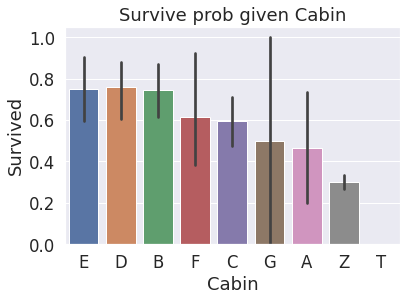

In [8]:
sns.barplot(
    x = 'Cabin',
    y = 'Survived',
    data = titanic_df,
    order = ['E', 'D', 'B', 'F', 'C', 'G', 'A', 'Z', 'T']
).set_title("Survive prob given Cabin")
plt.show()

Creación de nuevas columnas a partir del feature *Cabin*, también se agrupan en rangos la edad de los pasajeros.

In [9]:
titanic_df["Cabin_Low"] = titanic_df["Cabin"].apply(
    lambda x: 1 if str(x) in ["G", "A", "Z", "T"] else 0
)
titanic_df["Cabin_Middle"] = titanic_df["Cabin"].apply(
    lambda x: 1 if str(x) in ["F", "C"] else 0
)
titanic_df["Cabin_High"] = titanic_df["Cabin"].apply(
    lambda x: 1 if str(x) in ["E", "D", "B"] else 0
)

titanic_df["Age_g1"] = titanic_df["Age"].apply(
    lambda x: 1 if x <= 16 else 0
)
titanic_df["Age_g2"] = titanic_df["Age"].apply(
    lambda x: 1 if x > 16 and x <= 40 else 0
)
titanic_df["Age_g3"] = titanic_df["Age"].apply(
    lambda x: 1 if x > 40 and x <= 60 else 0
)
titanic_df["Age_g4"] = titanic_df["Age"].apply(
    lambda x: 1 if x >= 60 else 0
)

In [10]:
titanic_df.head()

,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,passenger_class,passenger_sex,passenger_survived,Embarked_S,Embarked_C,Embarked_Q,Lower_class,Middle_class,High_class,Sex,Survived,Cabin_Low,Cabin_Middle,Cabin_High,Age_g1,Age_g2,Age_g3,Age_g4
PassengerId,,,,,,,,,,,,,,,,,,,,,,,,,,
1,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,Z,S,Lower,M,N,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0
2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C,C,Upper,F,Y,0,1,0,0,0,1,0,1,0,1,0,0,1,0,0
3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,Z,S,Lower,F,Y,1,0,0,1,0,0,0,1,1,0,0,0,1,0,0
4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C,S,Upper,F,Y,1,0,0,0,0,1,0,1,0,1,0,0,1,0,0
5,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,Z,S,Lower,M,N,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0


### Gráficos descriptivos

A continuación se presentan gráficos que nos indican la probabilidad de supervivencia dada una variable puntual o categórica. Por ejemplo, en la gráfica (0,0) podemos observar que una persona de género femenino tendría una probabilidad mayor de sobrevivir. De la gráfica (2,1) se puede concluir que la probabilidad de supervivencia es mayor para las personas que viajaron en las cabinas "E, D y B".

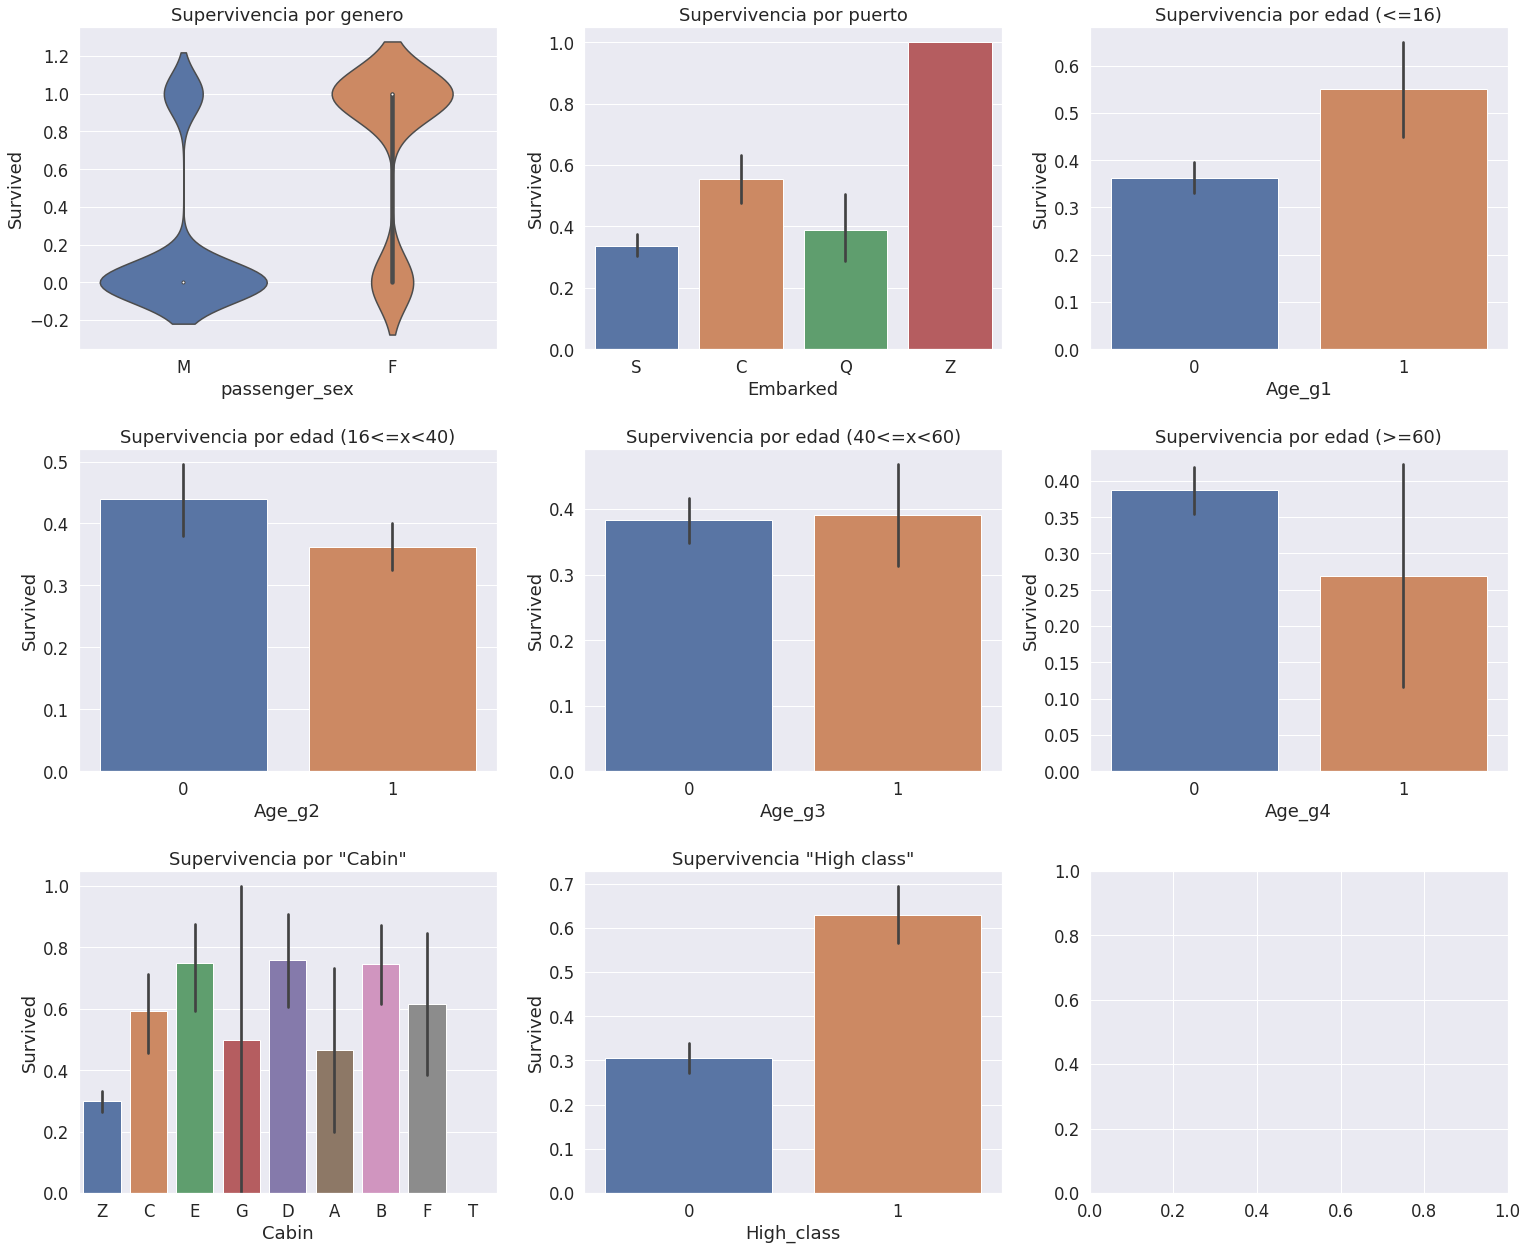

In [370]:
figure, ax = plt.subplots(3, 3, figsize=[22,18], )

sns.violinplot(x = 'passenger_sex', y = 'Survived', data = titanic_df, 
               ax = ax[0,0]).set_title("Supervivencia por genero")
sns.barplot(x = 'Embarked', y = 'Survived', data = titanic_df,
            ax = ax[0,1]).set_title('Supervivencia por puerto')
sns.barplot(x = "Age_g1", y = 'Survived', data = titanic_df,
            ax = ax[0,2]).set_title('Supervivencia por edad (<=16)')
sns.barplot(x = "Age_g2", y = 'Survived', data = titanic_df,
            ax = ax[1,0]).set_title('Supervivencia por edad (16<=x<40)')
sns.barplot(x = "Age_g3", y = 'Survived', data = titanic_df,
            ax = ax[1,1]).set_title('Supervivencia por edad (40<=x<60)')
sns.barplot(x = "Age_g4", y = 'Survived', data = titanic_df,
            ax = ax[1,2]).set_title('Supervivencia por edad (>=60)')
sns.barplot(x = 'Cabin', y = 'Survived', data=titanic_df,
            ax = ax[2,0]).set_title('Supervivencia por "Cabin"')
sns.barplot(x = 'High_class', y = 'Survived', data = titanic_df,
            ax = ax[2,1]).set_title('Supervivencia "High class"')

figure.tight_layout(pad=3.0)
plt.show()

Obtenemos las variables que se utilizaran como *features* para los modelos de clasificación propuestos.

In [12]:
titanic_df.head(2)

,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,passenger_class,passenger_sex,passenger_survived,Embarked_S,Embarked_C,Embarked_Q,Lower_class,Middle_class,High_class,Sex,Survived,Cabin_Low,Cabin_Middle,Cabin_High,Age_g1,Age_g2,Age_g3,Age_g4
PassengerId,,,,,,,,,,,,,,,,,,,,,,,,,,
1,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,Z,S,Lower,M,N,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0
2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C,C,Upper,F,Y,0,1,0,0,0,1,0,1,0,1,0,0,1,0,0


In [771]:
features = ["Parch", "Fare", "Sex", "Embarked_C", "Embarked_S",
            "Embarked_Q", "Lower_class", "Middle_class", "High_class",
             "Age"]

# Conjunto de datos
Y = titanic_df["Survived"].values
X = titanic_df[features].values

# Almacenamos una copia de los datos procesados
titanic_df[features].to_csv("/content/drive/My Drive/data_titanic_processed_no_label.csv")
X.shape, Y.shape

((891, 10), (891,))

Muestra del conjunto de datos final.

In [772]:
titanic_df[features].head()

,Parch,Fare,Sex,Embarked_C,Embarked_S,Embarked_Q,Lower_class,Middle_class,High_class,Age
PassengerId,,,,,,,,,,
1,0,7.2500,1,0,1,0,1,0,0,22.0
2,0,71.2833,0,1,0,0,0,0,1,38.0
3,0,7.9250,0,0,1,0,1,0,0,26.0
4,0,53.1000,0,0,1,0,0,0,1,35.0
5,0,8.0500,1,0,1,0,1,0,0,35.0




---


## Separación de los datos
Se obtendrán 3 conjuntos de datos:

- Entrenamiento
- Validación
- Test

Del conjunto inicial, se tomará un 20% para realizar pruebas y el 80% restante se utilizará para entrenamiento y validación.

In [773]:
# Separamos para (entrenamiento/validacion) y pruebas
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, 
                                                            test_size = 0.2,
                                                            shuffle = True,
                                                            random_state = 123)
# Datos de entrenamiento y validacion
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val,
                                                  test_size = 0.20,
                                                  shuffle = True,
                                                  random_state = 123)

Dimensiones de cada conjunto de Datos

In [774]:
X_train.shape, X_val.shape, X_test.shape

((569, 10), (143, 10), (179, 10))

### Funciones Auxiliares

In [808]:
# Hyperparameters per model
hyperparams = {"svm": "C",
               "logistic_regression": "lambda",
               "naive_bayes": "Comb"
}

def plot_accuracy(results_df, model):
  hyper = hyperparams.get(model)
  figure = plt.figure(figsize=(20,10), dpi=80)
  plt.plot(results_df[hyper], results_df.Train_Accuracy, 'green',
           results_df[hyper], results_df.Val_Accuracy, 'red');
  plt.legend(("Train Accuracy", "Validation Accuracy"));
  plt.title(model+" Accuracy")
  plt.show()

In [703]:
def get_metrics(y_hat, y):
  '''
  get_metrics: obtiene un conjunto de metricas a partir del conjunto de datos
  real y las predicciones hechas
  Input:
    y_hat - vector de predicciones
    y     - vector de valores reales
  Output:
    metrics:
      [0] - Accuracy
      [1] - F1 Score
      [2] - Precision Score
      [3] - Recall Score
  '''
  metrics = [mt.accuracy_score(y, y_hat, normalize=True),
             mt.f1_score(y, y_hat),
             mt.precision_score(y, y_hat),
             mt.recall_score(y, y_hat, average='weighted')]
  return metrics

## Support Vector Machine
 

In [559]:
# Importamos las librerías necesarias
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as mt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit

In [704]:
def train_svm(x_train, x_val, y_train, y_val, c):
  '''
  train_svm: Entrena una SVM
  Input: 
    x_train, y_train - Datos de entrenamiento
    x_val  , y_val   - Datos de validacion
    c, gamma         - Hiperparametros del modelo
  Output:
    svm_model     - Modelo final ajustado con los datos de entrenamiento
    train_metrics - Metricas del conjunto de entrenamiento
    val_metrics   - Metricas del conjunto de validación
  '''
  svm_model = Pipeline([
                        ("scaler", StandardScaler()),
                        ("svc", SVC(C=c, kernel='rbf', tol=0.001,
                                    max_iter=5000))                
        ])
  svm_model.fit(x_train, y_train)

  y_hat_train, y_hat_val = svm_model.predict(x_train), svm_model.predict(x_val)
  train_metrics = get_metrics(y_hat_train,y_train)
  val_metrics = get_metrics(y_hat_val, y_val)
  return svm_model, train_metrics, val_metrics
    

### Grid-search SVM
Implementaremos el algoritmo grid-search para encontrar el valor del hiperparametro *C* que nos da el valor máximo para la métrica Accuracy en el set de datos de entrenamiento y validación.[texto del vínculo](https://)

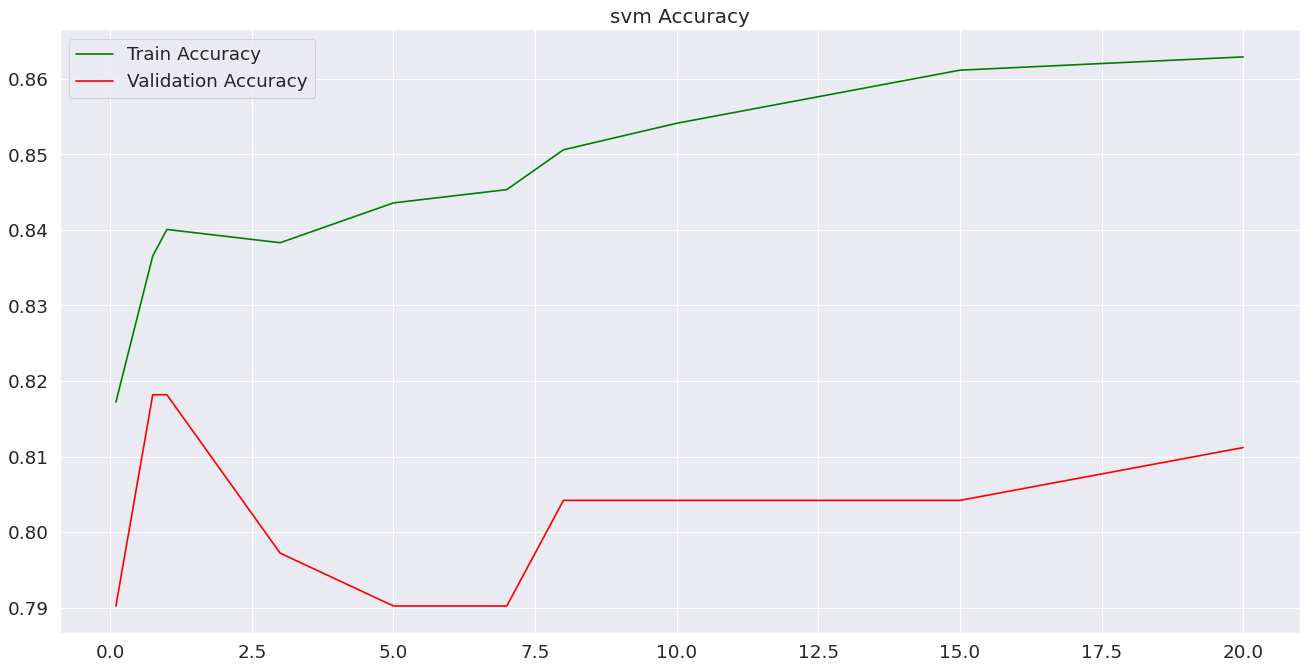

In [705]:
C_values = [0.1, 0.75, 1., 3., 5., 7., 8., 9., 10., 15., 20.]
tmetrics_list , vmetrics_list = [], []

for c in C_values:
  svm_m, tmetrics, vmetrics = train_svm(X_train, X_val, Y_train, Y_val, c)
  tmetrics_list.append(tmetrics.copy())
  vmetrics_list.append(vmetrics.copy())

svm_results = pd.DataFrame(np.column_stack((C_values,
                                           np.array(tmetrics_list),
                                           np.array(vmetrics_list))),
                           columns = ["C", "Train_Accuracy", "Train_F1",
                                      "Train_Precision", "Train_Recall",
                                      "Val_Accuracy", "Val_F1", "Val_Precision",
                                      "Val_Recall"])
plot_accuracy(svm_results, "svm")

Como observamos en la gráfica, el mejor modelo se produce cuando el hiperparametro **C** tiene un valor de 1.

### Guardamos el mejor modelo entrenado

In [706]:
# Entrenamos el modelo final con C=5.
svm_final, _, _ = train_svm(X_train, X_val, Y_train, Y_val, 1.)
# Guardamos el mejor modelo
joblib.dump(svm_final, "/content/drive/My Drive/svm_final_3.pkl")

['/content/drive/My Drive/svm_final_3.pkl']

## Logistic Regression Tensorflow
Implementación del modelo de regresión logística con regularización utilizando Tensorflow.

In [775]:
def train_logistic_regression(X_Train,Y_Train,learning_rate,l2_lambda,epochs,b_size=15):
  '''
  train_logistic_regression: Esta funcion permite entrenar un modelo de 
    regresion logistica implementado mediante la creacion de un grafo con las
    operaciones necesarias y se levanta una sesión para obtener el vector de 
    pesos W.
  Input:
    x_train, y_train - Set de Datos de entrenamiento
    lr               - learning rate para Gradient Descen
    l2_lambda        - Hyperparameter lambda para regularizacion L2
    epochs           - Cantidad de iteraciones
  '''
  # Agregamos el valor bias a X
  x_train = np.insert(X_Train, 0, 1, axis=1)
  y_train = Y_Train.reshape([-1, 1])
  m, n = x_train.shape
  #print(x_train.shape)
  # Creacion label para summary de tensorboard
  save_path = "/content/drive/My Drive/final_project_tfmodels/"
  summary_label = save_path+f"lr={learning_rate}_batch-size={b_size}_l2-lambda={l2_lambda}"
  tf.reset_default_graph()
  g = tf.Graph()
  # Definicion del grafo para Regresion Logística
  with g.as_default():
    # Creación de placeholders que manejara las variables de entrada
    X = tf.placeholder(tf.float32, shape = (None, n), name = "X")
    Y = tf.placeholder(tf.float32, shape = (None, 1), name = "Labels")
    # Hiperparametros
    lr = tf.placeholder(tf.float32, name = "lr")
    l2_reg = tf.placeholder(tf.float32, name = "lambda")
    # Parametros entrenables
    W = tf.get_variable("W", shape = [n, 1])
    #b = tf.Variable(tf.random_normal(shape=[1, 1]))
    # Logits para regresión binaria
    with tf.name_scope("Logits"):
      logits = tf.matmul(X, W, name = "Logits")
      y_hat = tf.round(tf.sigmoid(logits))
    with tf.name_scope("Accuracy"):
      correct = tf.cast(tf.equal(y_hat, Y), dtype=tf.float32)
      accuracy = tf.reduce_mean(correct, name = "Accuracy")
    # Funcion de Costo con Regularización L2
    with tf.name_scope("Funcion_de_Costo"):
      regularizer = tf.nn.l2_loss(W)
      cost_without_reg = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
          labels = Y, logits = logits), name = "Cost_without_Reg")
      cost = tf.add(cost_without_reg, tf.multiply(l2_reg, regularizer), name = "Cost")
      cost_sum = tf.summary.scalar("Cost_sum", cost)
    # Gradient Descent
    with tf.name_scope("Gradient_Descent"):
      optimizer = tf.train.GradientDescentOptimizer(lr).minimize(cost)

  # Entrenamiento del modelo
  total_iteraciones = int(m / b_size)
  with tf.Session(graph = g) as s:
    writer = tf.summary.FileWriter(summary_label, graph=g)
    s.run(tf.global_variables_initializer())
    iter_cnt = 0
    for epoch in range(epochs):
      for i in range(total_iteraciones):
        start_idx = (i*b_size) % m
        idx = np.arange(m)[start_idx:start_idx+b_size]
        x_batch = x_train[idx, :]
        y_batch = y_train[idx]

        feed_dict = {X: x_batch, Y: y_batch, lr: learning_rate,
                     l2_reg: l2_lambda}
        _, c_, c_sum, acc = s.run([optimizer, cost, cost_sum, accuracy],
                      feed_dict=feed_dict)
        writer.add_summary(c_sum, epoch*total_iteraciones + i + 1)
        if (epoch % 50 == 0) and (iter_cnt % 100 ==0):
          print(f"Epoch: {epoch+1}, -- Costo: {c_} - Acc:{acc}")
        iter_cnt += 1
    W_params = s.run(W)

  return W_params

In [776]:
def inference_log_reg(x, weights):
  def sigmoid(l):
    return (1 / (1 + np.exp(-l)))
  x_f = np.insert(x, 0, 1, axis=1)
  logits = np.matmul(x_f, weights)
  y_hat = 1.0*(sigmoid(logits) > 0.5)

  return y_hat

### Grid-search Logistic Regression
Se tratará de encontrar el valor de $\lambda$ y el batch_size

In [ ]:
lambda_vals = [0.000000001,0.00001, 0.0001, 0.001, 0.01, 0.1, 1.]
batch_vals = [64, 128, 256, 300, 400, 569]
#lambda_vals = [0.001, 0.01, 0.1, 1., 10.]
#batch_vals = [256, 569]
tmetrics_list , vmetrics_list = [], []
labels = []

for l in lambda_vals:
  for b in batch_vals:
    print(f"Lambda:{l}, Batch_size:{b}")
    labels.append([l,b])
    weights = train_logistic_regression(X_train, Y_train, learning_rate=0.1,
                                        l2_lambda = l, epochs = 1000, b_size = b)
    tmetrics = get_metrics(inference_log_reg(X_train, weights), Y_train)
    vmetrics = get_metrics(inference_log_reg(X_val, weights), Y_val)
    tmetrics_list.append(tmetrics.copy())
    vmetrics_list.append(vmetrics.copy())

log_reg_results = pd.DataFrame(np.column_stack((np.array(labels), np.array(tmetrics_list),
                                                np.array(vmetrics_list))),
                           columns = ["Lambda", "Batch_Size", "Train_Accuracy", 
                                      "Train_F1", "Train_Precision", "Train_Recall",
                                      "Val_Accuracy", "Val_F1", "Val_Precision",
                                      "Val_Recall"])

In [760]:
log_reg_results.head()

,Lambda,Batch_Size,Train_Accuracy,Train_F1,Train_Precision,Train_Recall,Val_Accuracy,Val_F1,Val_Precision,Val_Recall
0,1.000000e-09,64.0,0.794376,0.738255,0.743243,0.794376,0.650350,0.193548,0.857143,0.650350
1,1.000000e-09,128.0,0.796134,0.741071,0.744395,0.796134,0.615385,0.000000,0.000000,0.615385
2,1.000000e-09,256.0,0.792619,0.731818,0.748837,0.792619,0.657343,0.309859,0.687500,0.657343
3,1.000000e-09,300.0,0.780316,0.720358,0.725225,0.780316,0.678322,0.540000,0.600000,0.678322
4,1.000000e-09,400.0,0.787346,0.726862,0.738532,0.787346,0.650350,0.418605,0.580645,0.650350


In [786]:
# En este caso obtuvimos un accuracy de 68% para el conjunto de validacion
Weights = train_logistic_regression(X_train,Y_train,0.001,l2_lambda=0.0001,
                                    epochs=3000,b_size=569)

Epoch: 1, -- Costo: 17.65864372253418 - Acc:0.3936731219291687
Epoch: 101, -- Costo: 0.6568484902381897 - Acc:0.6660808324813843
Epoch: 201, -- Costo: 0.6548978686332703 - Acc:0.6678383350372314
Epoch: 301, -- Costo: 0.6529704332351685 - Acc:0.6678383350372314
Epoch: 401, -- Costo: 0.6510655879974365 - Acc:0.6695957779884338
Epoch: 501, -- Costo: 0.6491831541061401 - Acc:0.6695957779884338
Epoch: 601, -- Costo: 0.6473231315612793 - Acc:0.671353280544281
Epoch: 701, -- Costo: 0.6454851627349854 - Acc:0.671353280544281
Epoch: 801, -- Costo: 0.6436689496040344 - Acc:0.671353280544281
Epoch: 901, -- Costo: 0.6418744325637817 - Acc:0.671353280544281
Epoch: 1001, -- Costo: 0.6401011347770691 - Acc:0.6731107234954834
Epoch: 1101, -- Costo: 0.6383492946624756 - Acc:0.6731107234954834
Epoch: 1201, -- Costo: 0.6366181969642639 - Acc:0.6748681664466858
Epoch: 1301, -- Costo: 0.6349078416824341 - Acc:0.6748681664466858
Epoch: 1401, -- Costo: 0.6332180500030518 - Acc:0.6748681664466858
Epoch: 1501,

### Guardamos el mejor modelo entrenado

In [787]:
#Almacenamos el
print(get_metrics(inference_log_reg(X_train, Weights), Y_train))
#np.savez(file = "/content/drive/My Drive/reg_log_weights.npz", W = Weights)

[0.6889279437609842, 0.445141065830721, 0.7473684210526316, 0.6889279437609842]


In [615]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir "/content/drive/My Drive/final_project_tfmodels/"

## Modelo de clasificación Naïve Bayes

Utilizaremos la implementación de *sklearn* para la implementación de este modelo y se ajustaran los hiperparametros utilizando **Grid-Search**

In [788]:
from sklearn.naive_bayes import GaussianNB

Prueba utilizando todas las variables

In [791]:
modelNB = GaussianNB()
modelNB.fit(X_train, Y_train)

get_metrics(modelNB.predict(X_val), Y_val)

[0.7552447552447552, 0.6601941747572816, 0.68, 0.7552447552447552]

### Implementacion Grid-Search

In [807]:
# Se almacena en una lista las combinaciones que queremos probar
comb_vals = [[0,1,2,3,4,5,6,7,8,9],
             [0,1,2,3,4,5,6,9],
             [6,7,8,9],
             [1,2,6,7,8,9],
             [1,2,3,4,5,9],
             [0,1,2,9],
             [2,9],
             [1,2,9],
             [0,1,2],
             [2,6,7,8]]

tmetrics_list, vmetrics_list = [], []

for comb in comb_vals:
  modelNB = GaussianNB()
  modelNB.fit(X_train[:, comb], Y_train)
  tmetrics = get_metrics(modelNB.predict(X_train[:, comb]), Y_train)
  vmetrics = get_metrics(modelNB.predict(X_val[:, comb]), Y_val)
  tmetrics_list.append(tmetrics.copy())
  vmetrics_list.append(vmetrics.copy())

NB_results = pd.DataFrame(np.column_stack((np.array([0,1,2,3,4,5,6,7,8,9]),
                                           np.array(tmetrics_list),
                                           np.array(vmetrics_list))),
                           columns = ["Comb", "Train_Accuracy", "Train_F1",
                                      "Train_Precision", "Train_Recall",
                                      "Val_Accuracy", "Val_F1", "Val_Precision",
                                      "Val_Recall"])

#plot_accuracy(NB_results, "naive-bayes")

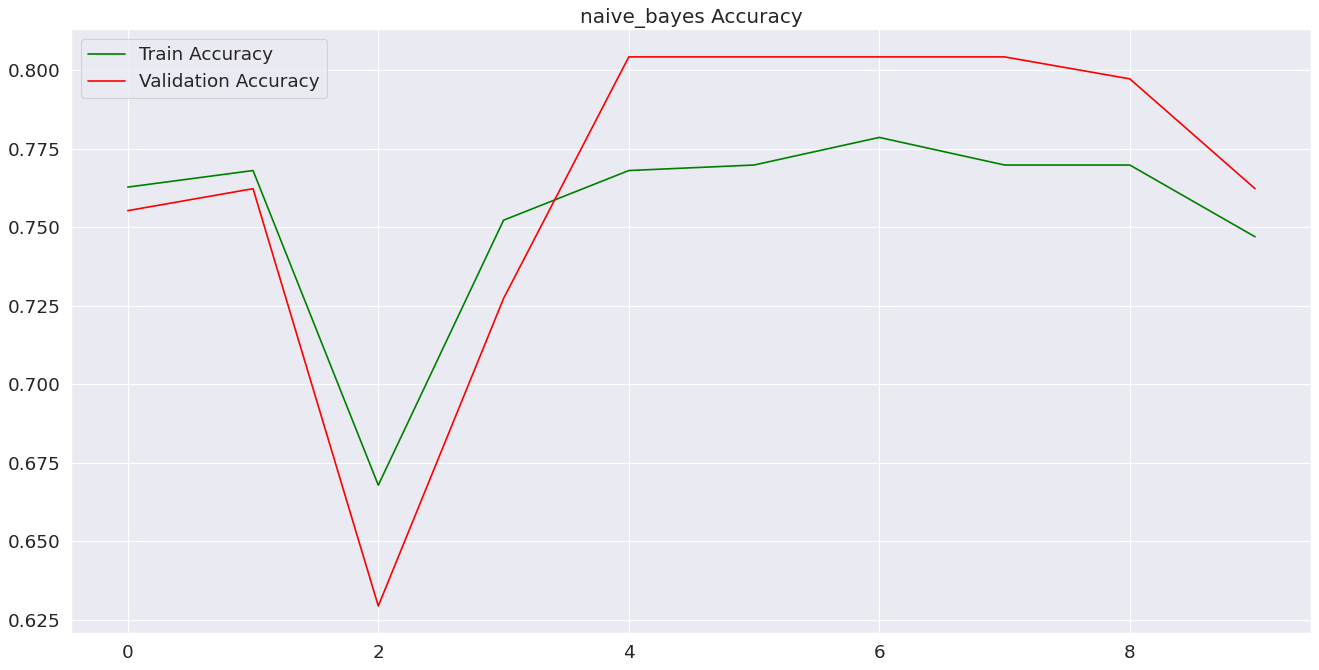

In [809]:
plot_accuracy(NB_results, "naive_bayes")

Seleccionamos la mejor combinación que tiene el índice 6, se traduce a las columnas "Sex" y "Age" lo que nos indica que tan influyentes son.

In [812]:
comb_vals[6]
final_NB = GaussianNB()
final_NB.fit(X_train[:, comb_vals[6]], Y_train)

# Almacenamos el modelo
joblib.dump(final_NB, "/content/drive/My Drive/final_NB.pkl")

['/content/drive/My Drive/final_NB.pkl']